# Presents all data from the Frequency Response Magnetophosphene study
## effect of ELF-MF (up to 300Hz) on magnetophosphene perception threshold

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

rcParams['figure.figsize'] = 10, 10
sns.set_style("whitegrid")

%matplotlib inline

/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
filename = '../DATA/All_Thresholds.txt'
data = pd.read_csv(filename,sep='\t')
data['Perceived'] = data.Threshold > 0  # perceived if threshold value
data.head()

,ID,Iteration,Frequency,Threshold,Yes/No,Perceived
0,P1,1,25,14.167777,NaN,True
1,P1,2,10,14.531105,NaN,True
2,P1,3,65,58.395892,NaN,True
3,P1,4,80,NaN,NaN,False
4,P1,5,250,NaN,NaN,False


## extract percentage of perception for each frequency

In [6]:
frequencies = data.Frequency.unique()
frequencies.sort()

In [7]:
distr_perceived = pd.Series(index = frequencies)

for fr in frequencies:
    df = data.loc[data['Frequency']==fr,'Perceived']
    if df.any():
        percentage = df.value_counts()[True]/df.value_counts().sum()
    else:
        percentage = 0
    
    distr_perceived[fr] = percentage

/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [8]:
df

15      False
23      False
68      False
98      False
116     False
        ...  
2776    False
2805    False
2821    False
2897    False
2899     True
Name: Perceived, Length: 116, dtype: bool

Text(0, 0.5, 'Perception rate %')

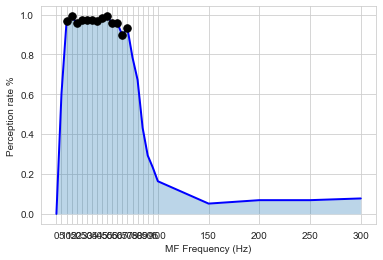

In [9]:
fig, ax  = plt.subplots()
ax.plot(distr_perceived.index, distr_perceived, color='blue', lw='2')
ax.fill_between(distr_perceived.index, 0, distr_perceived, alpha=.3)

ax.plot(distr_perceived[distr_perceived > 0.8], 'k.', ms=15)
# ax.plot(distr_perceived[distr_perceived > 0.95], 'r.')

plt.xticks(frequencies)
plt.xlabel('MF Frequency (Hz)')
plt.ylabel('Perception rate %')

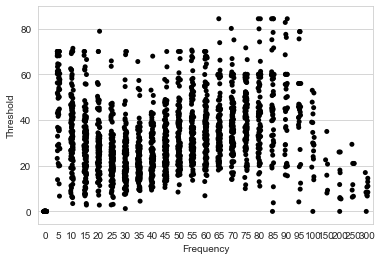

In [10]:
# plt.scatter(data.Frequency, data.Threshold)
plt.figure()
sns.stripplot(x="Frequency", y="Threshold", data=data, color='black')

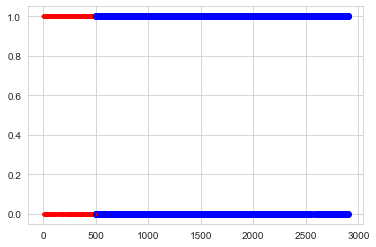

In [8]:
plt.figure()
plt.plot(data.index, data.Threshold > 0, 'r.')
plt.plot(data.index, data['Yes/No'], 'bo', fillstyle='none')

## polynomial regression

In [11]:
data = data.set_index('Frequency')
idxFreq = distr_perceived[distr_perceived >0.8].index
data

,ID,Iteration,Threshold,Yes/No,Perceived
Frequency,,,,,
25,P1,1,14.167777,NaN,True
10,P1,2,14.531105,NaN,True
65,P1,3,58.395892,NaN,True
80,P1,4,NaN,NaN,False
250,P1,5,NaN,NaN,False
...,...,...,...,...,...
20,P60,46,22.616422,1.0,True
250,P60,47,11.712468,1.0,True
300,P60,48,NaN,0.0,False


In [12]:
# new_data = data.loc[idxFreq].dropna(subset=["Threshold"]) ## remove rows with no perception
new_data = data[data['Perceived']].loc[idxFreq]

### Using sklearn linear_model - polynomialFeatures
(can be done with numpy poly1d)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [14]:
Freq = new_data.index.to_numpy()
Thres = new_data.Threshold
nFreq = np.arange(0,150)

x = Freq[:, np.newaxis]
y = Thres[:, np.newaxis]
new_x = np.arange(0,150)[:,np.newaxis]

polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)
newx_poly = polynomial_features.fit_transform(new_x)

model = LinearRegression()

# linear regression
model.fit(x, y)
y_pred = model.predict(new_x)

# polynomial regression
model.fit(x_poly, y)
ypol_predict = model.predict(newx_poly)

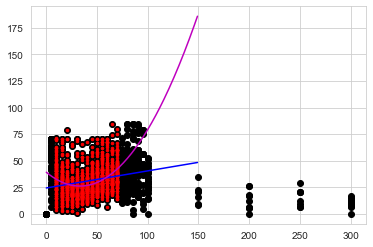

In [15]:
plt.figure()
plt.scatter(data.index, data.Threshold, color='k')

plt.plot(Freq, Thres, 'r.', ms=5)
plt.plot(new_x, y_pred, 'blue')
plt.plot(new_x, ypol_predict, 'm')

### Using StatsModels for statistics
https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html

In [16]:
import statsmodels.api as sm

In [17]:
s_model = sm.OLS(y, x_poly).fit()
sy_pred = s_model.predict(x_poly)

In [18]:
s_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     97.61
Date:                Fri, 27 Mar 2020   Prob (F-statistic):           1.70e-40
Time:                        09:36:13   Log-Likelihood:                -5775.0
No. Observations:                1452   AIC:                         1.156e+04
Df Residuals:                    1449   BIC:                         1.157e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.1624      1.580     24.794      0.000      36.064      42.261
x1            -0.7871      0.089     -8.817      0.000      -0.962      -0.612
x2             0.0119      0.001     10.845      0.000       0.010       0.014
==============================================================================
Omnibus:                      173.877   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.584
Skew:                           0.888   Prob(JB):                     1.05e-54
Kurtosis:                       3.978   Cond. No.                     1.14e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
predictions = s_model.get_prediction(newx_poly)
toto = predictions.summary_frame(alpha=0.01)

In [20]:
toto

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,39.162374,1.579530,35.088409,43.236339,5.571885,72.752863
1,38.387213,1.497072,34.525926,42.248500,4.821854,71.952572
2,37.635831,1.417149,33.980683,41.290979,4.093561,71.178101
3,36.908228,1.339802,33.452575,40.363880,3.387110,70.429345
4,36.204403,1.265077,32.941484,39.467323,2.702606,69.706201
...,...,...,...,...,...,...
145,175.017288,11.901475,144.320689,205.713887,129.696156,220.338420
146,177.690089,12.132940,146.396488,208.983690,131.962491,223.417688
147,180.386670,12.366603,148.490399,212.282940,134.244543,226.528796
148,183.107029,12.602463,150.602422,215.611636,136.542308,229.671750


In [21]:
predictions = s_model.get_prediction(newx_poly)

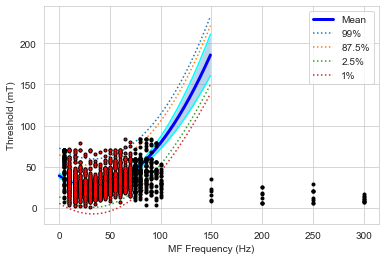

In [22]:
conf_95 = predictions.summary_frame()
conf_01 = predictions.summary_frame(alpha=0.01)

fig, ax1 = plt.subplots()
plt.plot(new_x,conf_95['mean'],'b', linewidth=3, label="Mean")
plt.plot(new_x,conf_95['mean_ci_lower'],'cyan')
plt.plot(new_x,conf_95['mean_ci_upper'],'cyan')
plt.fill_between(conf_95.index, conf_95.mean_ci_lower, conf_95.mean_ci_upper, alpha=.3)

plt.plot(new_x,conf_01.obs_ci_upper,':',label="99%")
plt.plot(new_x,conf_95.obs_ci_upper,':',label="87.5%")
plt.plot(new_x,conf_95.obs_ci_lower,':',label="2.5%")
plt.plot(new_x,conf_01.obs_ci_lower,':',label="1%")

plt.plot(data[data['Perceived']].index, data[data['Perceived']].Threshold, 'k.')
plt.plot(Freq, Thres, 'r.', ms=2)

plt.xlabel('MF Frequency (Hz)')
plt.ylabel('Threshold (mT)')

plt.legend()

# plot perception rate
if False:
    ax2 = ax1.twinx()
    ax2.plot(distr_perceived.index, distr_perceived, color='blue', lw='0.5')
    ax2.fill_between(distr_perceived.index, 0, distr_perceived, alpha=.1)

In [23]:
fig.savefig('../ThresholdModels.png',dpi=300)

In [25]:
# data[data.Threshold > 70].to_csv('HighThreshold.csv')

___
## __Explore first 12 subjects__

In [26]:
data.ID.unique()

array(['P1', 'P2', 'P3', 'P4', 'P5', 'P7', 'P8', 'P9', 'P10', 'P12',
       'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30',
       'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39',
       'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48',
       'P49', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57',
       'P58', 'P59', 'P60'], dtype=object)

In [27]:
bID = ['P1', 'P2', 'P3', 'P4', 'P5', 'P7', 'P8', 'P9', 'P10', 'P12']

In [28]:
df = data.loc[data.ID.isin(bID),:]

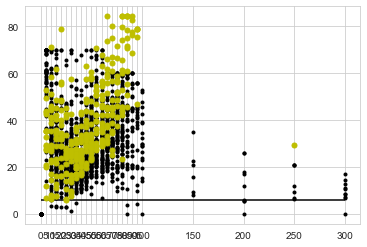

In [40]:
plt.plot(data.index, data.Threshold, 'k.')
plt.plot(df.index, df.Threshold, 'y.', ms=10)
plt.xticks(ticks=frequencies, labels=frequencies)
plt.hlines(y=6, xmin=0, xmax=300)

___
## __Explore P50 with low thresholds__

In [36]:
data[(data.Threshold < 6) & (data.Threshold > 0)].ID.unique()

array(['P28', 'P50', 'P51', 'P54'], dtype=object)

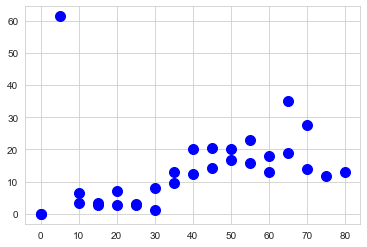

In [30]:
plt.plot(data[data.ID=='P50'].index, data[data.ID=='P50'].Threshold, 'b.', ms=20)

---
# __Threshold Methods P59__

In [37]:
pd.options.display.max_rows = 50

In [38]:
data[data.ID=='P59'].sort_index()

,ID,Iteration,Threshold,Yes/No,Perceived
Frequency,,,,,
0,P59,31,0.000000,0.0,False
0,P59,15,0.000000,0.0,False
5,P59,35,NaN,0.0,False
5,P59,16,50.115219,1.0,True
10,P59,28,25.544469,1.0,True
10,P59,10,NaN,0.0,False
15,P59,25,13.151598,1.0,True
15,P59,5,6.817248,1.0,True
20,P59,37,21.382451,1.0,True


## read different threshold assessment 

In [41]:
df59_b = pd.read_csv("B_Threshold.csv",header=None, names='B')
df59_mf = pd.read_csv("MF_Threshold.csv",header=None, names=["MF"])
df59_rms = pd.read_csv("rms_Threshold.csv",header=None, names=["rms"])
new_df = data[['ID', 'Threshold', 'Yes/No']].query('ID == "P59"').reset_index()
new_df.insert(3, 'new_th',new_df['Yes/No'].mul(df59_b.B))

In [42]:
new_df

,Frequency,ID,Threshold,new_th,Yes/No
0,55,P59,26.985499,28.4660,1.0
1,80,P59,NaN,0.0000,0.0
2,150,P59,NaN,0.0000,0.0
3,75,P59,45.557987,48.0520,1.0
4,15,P59,6.817248,7.4141,1.0
5,300,P59,NaN,0.0000,0.0
6,65,P59,42.069701,43.4040,1.0
7,40,P59,23.200121,23.8220,1.0
8,100,P59,NaN,0.0000,0.0
9,10,P59,NaN,0.0000,0.0


Text(0, 0.5, 'Threshold rms  - B (mT)')

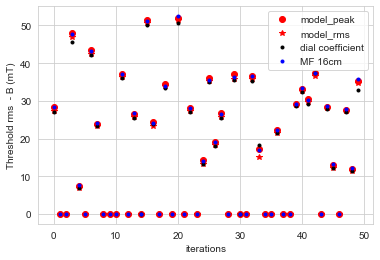

In [43]:
plt.plot(new_df['new_th'],'ro', label='model_peak')
plt.plot(df59_rms.rms.mul(new_df['Yes/No']),'r*', label='model_rms')
plt.plot(new_df['Threshold'],'k.', label='dial coefficient')
plt.plot(df59_mf.MF.mul(new_df['Yes/No']),'b.', label='MF 16cm')


plt.legend()
plt.xlabel('iterations')
plt.ylabel('Threshold rms  - B (mT)')